# Brachistochrone

A complete guide to understand the Brachistochrone problem can be
found here [(german resource)](https://de.wikipedia.org/wiki/Brachistochrone),
or here on [english](https://en.wikipedia.org/wiki/Brachistochrone_curve).

This problem is basically a curve (slide alike path) which gives the fastest descend between
a high starting point $A$, and a lower finish point $B$.

# Problem definition

To model this problem, we use a function $u(t)$ which maps for
each instant of time an angle direction with respect to the $(x, y)$ coordinates.
<center>

\begin{align}
\min_{u} T \\
\textrm{s.t.} \\
\dot x &= v(t)cos(u(t)) \\
\dot y &= -v(t)sin(u(t) \\
\dot v &= 9.81sin(u(t) \\
\end{align}

----------------------------------------------------------

\begin{align}
x(0) &= 0 \\
v(0) &= 0 \\
x(T) &= 1
\end{align}

----------------------------------------------------------

![Brachistochrone concept image](https://cdn.thingiverse.com/renders/84/1e/85/89/8c/d5a57c0790f41289c92a57cfa2414315_preview_featured.jpg)

In [1]:
# importing required packages.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as env
import pyomo.dae as dae
import plotly.express as px

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 97
  Number of variables: 113
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.03091883659362793
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


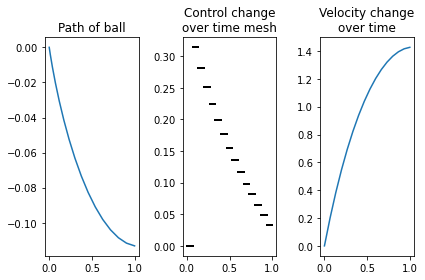

In [72]:
# %% formulate Model
# initialize general tuning variables
g = 9.81  # Gravity
t_f = 1

# initialize model object
Model = env.ConcreteModel()

# initialize time variable
Model.tf = env.Var(domain=env.NonNegativeReals)
Model.t = dae.ContinuousSet(bounds=(0, t_f))

# define control
Model.u = env.Var(Model.t)

# define dependent variables
Model.x = env.Var(Model.t)
Model.y = env.Var(Model.t)
Model.v = env.Var(Model.t)

# define derivatives
Model.x_dot = dae.DerivativeVar(Model.x)
Model.y_dot = dae.DerivativeVar(Model.y)
Model.v_dot = dae.DerivativeVar(Model.v)

# define ODE constraints
Model.ode_x = env.Constraint(Model.t, rule=lambda m, t: m.x_dot[t] == m.v[t]*env.cos(m.u[t]))
Model.ode_y = env.Constraint(Model.t, rule=lambda m, t: m.y_dot[t] == -m.v[t]*env.sin(m.u[t]))
Model.ode_v = env.Constraint(Model.t, rule=lambda m, t: m.v_dot[t] == g*env.sin(m.u[t]))

# set initial and final conditions
Model.bounds = env.ConstraintList()
Model.bounds.add(Model.x[0] == 0)
Model.bounds.add(Model.v[0] == 0)
Model.bounds.add(Model.y[0] == 0)
Model.bounds.add(Model.x[t_f] == 1)

# define model objective
Model.objective = env.Objective(rule=lambda model: model.tf)

# %% solve System
env.TransformationFactory('dae.finite_difference').apply_to(Model, wrt=Model.t, nfe=15)
env.SolverFactory('ipopt').solve(Model,tee=False).write()

# %% basic Plot
# define variables
time = np.array([t for t in Model.t])
u = np.array([Model.u[t]() for t in Model.t])
velocity = np.array([Model.v[t]() for t in Model.t])
v = np.array([str(np.round(Model.v[t](), 2))+" m/s" for t in Model.t])
x = np.array([Model.x[t]() for t in Model.t])
y = np.array([Model.y[t]() for t in Model.t])
solution_data = pd.DataFrame(data={'control': u,
                                   'velocity': v,
                                   'time': time,
                                   'x': x,
                                   'y': y})

# create path and control plotting
fig, axes = plt.subplots(nrows=1, ncols=3)

# path plotting
axes[0].plot(x, y)
axes[0].set_title("Path of ball")

# control plotting
for i in range(np.size(u)-1):
    u_temp = ([u[i], u[i]])
    x_temp = ([time[i], time[i+1]])
    axes[1].plot(x_temp, u_temp, '-', lw=2, color='k')
axes[1].set_title("Control change\nover time mesh")

# aceleration plotting
axes[2].plot(time, velocity)
axes[2].set_title("Velocity change\nover time")

fig.tight_layout()
plt.show()

* First plot shows the optimized for velocity path of the ball. It is forseable that the path angle changes more as long as the transcurred distance gets closer to the final position.
* The center plot shows the change of the angle respect to the time by intervals calculated from the discretization mesh.
* The third plot shows the change of velocity over time. Showing how the change of angles leads to increase of acceleration on a quadratic way.

### Warning
This plotly animation require some packages to work properly on specific notebooks displayers. 
This version was tested specifically on `jupyter-notebooks==6.1.6` using `plotly==4.14.3`.

In [53]:
# descend animation
radius = 0.05
ball_size = np.repeat(radius, x.size)
animation = px.scatter(solution_data, 
                       x='x', 
                       y=solution_data.y+radius/5.5,
                       animation_frame='time',
                       text='velocity',
                       size=ball_size,
                       title="Brachistochrone path (velocity as overlay number)")
animation.add_traces(px.line(solution_data, x='x', y='y').data[0])
animation.update_traces(marker_color='red')
animation.show()